# Are you on PC or MAC? pc = 0, mac = 1

In [22]:
computer = 1
#! source activate tensorflow

# 1) Libraries

In [23]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from time import time

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

# 2) Import

In [24]:
# Comprehensive way to set the path to Data directory

ROOTPATH = os.getcwd()

path_data = os.path.join(ROOTPATH, 'Data')
path_train = os.path.join(path_data, 'train_set')
path_test = os.path.join(path_data, 'test_set')
path_validation = os.path.join(path_data, 'validation_set')

## Import the list of tickers

In [25]:
if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1

if computer == 1:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1            

list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")
list_tickers.remove("SNDX")

## Importing functions

In [26]:
def get_data(path):
    list_dataframes=[]
    allFiles = glob.glob(path + "/csv" + "*.csv")
    i = 0
    list_tickers = []
    
    if computer == 0:
        for file_ in allFiles:
            with open(file_, 'r') as csvfile:
                list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
                list_tickers.append(file_.split('_')[4])
                i+=1

    if computer == 1:
        for file_ in allFiles:
            with open(file_, 'r', encoding ='mac_roman') as csvfile:
                list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
                list_tickers.append(file_.split('_')[4])
                i += 1
    
    num_files = i
    
    return num_files, list_dataframes, list_tickers


In [27]:
def normalize_data(num_files, list_dataframes, list_tickers):
    
    maxi = 0
    length = 0
    compt = 0
    j = 0
    
    for df in list_dataframes:
        if len(df) > maxi:
            maxi = len(df['Adj Close'])
    
    data = np.array([np.zeros(maxi)]*(num_files))
    data_normalized = np.array([np.zeros(maxi)]*(num_files))
    
    i = 0
    
    for df in list_dataframes:
        arr = np.array(df['Adj Close'])
        if len(arr) == maxi and not df['Adj Close'].isnull().values.any(): 
            data[j] = arr
            minimum = np.min(arr)
            maximum = np.max(arr)
            arr = (arr - minimum) / (maximum - minimum)
            data_normalized[j] = arr
            j += 1
        else:
            list_tickers.pop(i)
            compt += 1
            i-=1
        i += 1
    
    return data_normalized[:-compt], data[:-compt], list_tickers

## Create training, validation and testing set

In [28]:
train_setDf = get_data(path_train)

validation_setDf = get_data(path_validation)

test_setDf = get_data(path_test)

In [29]:
train_setData_n, train_setData, list_tickers_train = normalize_data(train_setDf[0], train_setDf[1], train_setDf[2])

validation_setData_n, validation_setData, list_tickers_val = normalize_data(validation_setDf[0], validation_setDf[1], validation_setDf[2])

test_setData_n, test_setData, list_tickers_test = normalize_data(test_setDf[0], test_setDf[1], test_setDf[2])

print("train_setData is of length : ",len(train_setData))
print("test_setData is of length : ",len(test_setData))
print("validation_setData is of length : ",len(validation_setData))

train_setData is of length :  114
test_setData is of length :  28
validation_setData is of length :  27


# 3) Functions

## Initializing functions

In [94]:
def variable_summary_light(var):
    with tf.variable_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)

In [95]:
def next_batch(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [96]:
def layer_batch_normalization(x, n_out, phase_train):

    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)

    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
        
    mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))

    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    
    return tf.reshape(normed, [-1, n_out])

In [97]:
def layer(input_tensor, num_input, num_output, phase_train, layer_name):
    with tf.variable_scope(layer_name):
        with tf.variable_scope('weights'):
            weight_init = tf.random_normal_initializer(stddev=1.0/np.sqrt(num_input))
            weight_shape = [num_input, num_output]
            W = tf.get_variable('W', weight_shape, initializer = weight_init)
            variable_summary_light(W)
    
        bias_shape = [num_output]
        bias_init = tf.constant_initializer(value = 0)
        b = tf.get_variable('b', bias_shape, initializer = bias_init)
    
        logits = tf.matmul(input_tensor, W) + b
    
    return tf.nn.relu(layer_batch_normalization(logits, num_output, phase_train)), W

In [98]:
def encoder(input_tensor, num_input, num_output, phase_train):
    with tf.variable_scope("encode"):
        
        with tf.variable_scope('output'):
            output, W_e = layer(input_tensor, num_input, num_output, phase_train, "encoder")
            
    return output, W_e

def decoder(input_tensor, num_input, num_output, phase_train):
    with tf.variable_scope("decode"):
        
        with tf.variable_scope('output'):
            output, W_d = layer(input_tensor, num_input, num_output, phase_train, "decoder")
            
    return output, W_d


In [99]:
def droupout(encoder_op, keep_prob):
    with tf.variable_scope("dropped"):
        dropped = tf.nn.dropout(encoder_op, keep_prob)
    return dropped

In [100]:
def mse(output, x):
    with tf.variable_scope('mse'):
        mse = tf.squared_difference(output, x)
    return mse

In [101]:
def regularizer(W_e, W_d):
    with tf.variable_scope("regularizer"):
        regularizer = tf.nn.l2_loss(W_e) + tf.nn.l2_loss(W_d)
    return regularizer

In [102]:
def loss(mse, regularizer, lambd, num_input, batch_size):
    with tf.variable_scope("loss"):
        loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)
    return loss

In [103]:
def training(loss, learning_rate):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    return train_op

In [104]:
def evaluate(output, x):
    with tf.variable_scope('validation'):
        
        l2_norm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        
        val_loss = tf.reduce_mean(l2_norm)
        
        val_summary_op = tf.summary.scalar("val_cost", val_loss)
        
        return val_loss, val_summary_op

In [107]:
# Training Parameters
learning_rate = 0.001
num_steps = 300
batch_size = 10
lambd = 0.1
droup_out = 0.9

display_step = 100

# Network Parameters 

num_input = 503 # 503 days considered
num_hidden_1 = 250 # 1st layer num features
num_output = num_input

date = str(int(time()))

logs_path = '/tmp/tensorflow_logs/autoencoder1/'+date+'/'

with tf.Graph().as_default():
    with tf.variable_scope("autoencoder_model"):
        
        x = tf.placeholder("float", [None, num_input])
        
        phase_train = tf.placeholder(tf.bool)
        
        code, W_e = encoder(x,num_input, num_hidden_1, phase_train)
        
        output, W_d = decoder(code, num_hidden_1, num_output, phase_train)
        
        cost = loss(mse(output,x), regularizer(W_e, W_d), lambd, num_input, batch_size)
        
        train_op = training(cost, learning_rate)
        
        eval_op, val_summary_op = evaluate(output, x)
        
        summary_op = tf.summary.merge_all()
        
        saver = tf.train.Saver()
        
        sess = tf.Session()
        
        summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
        
        init_op = tf.global_variables_initializer()
        
        sess.run(init_op)
        
        start_time = time()
        
        for i in range(1, num_steps+1):
            
            # Prepare Data
            total_batch = int(len(train_setData_n)/batch_size)

            for j in range(total_batch):
                mini_batch_x, _ = next_batch(batch_size,train_setData_n,train_setData_n)

                _, l, summary = sess.run([train_op, cost, summary_op], 
                            feed_dict={x: mini_batch_x, phase_train: True})

            # Write on the log file the datas for TensorBoard / First: summary, Second: overall step
            summary_writer.add_summary(summary, i)
                
            if i % display_step == 0 or i == 1:
                
                print('Step %i: Minibatch Loss: %f' % (i, l))
                curr_time = time()
                elapsed_time = curr_time-start_time
                print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')
                    
#                 print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost))

#                 train_writer.add_summary(train_summary, sess.run(global_step))

#                 validation_loss, in_image, out_image, val_summary = sess.run([eval_op, val_summary_op], feed_dict={x: validation_setData, phase_train: False})

#                 val_writer.add_summary(in_image, sess.run(global_step))
#                 val_writer.add_summary(out_image, sess.run(global_step))
#                 val_writer.add_summary(val_summary, sess.run(global_step))

#                 print("Validation Loss:", validation_loss)

#                 save_path = saver.save(sess, model_path)
#                 print("Model saved in file: %s" % save_path)

#                 curr_time = time()
#                 elapsed_time = curr_time-start_time
#                 print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')

Step 1: Minibatch Loss: 14.221178
Estimated remaining time =  39.29847002029419 s

Step 100: Minibatch Loss: 0.036467
Estimated remaining time =  16.88039779663086 s

Step 200: Minibatch Loss: 0.012757
Estimated remaining time =  8.210269093513489 s

Step 300: Minibatch Loss: 0.013163
Estimated remaining time =  0.0 s



In [106]:
with tf.Graph().as_default():
    with tf.variable_scope("autoencoder_model"):

SyntaxError: unexpected EOF while parsing (<ipython-input-106-7a3844783128>, line 2)

## Training functions

## Tensorboard functions

## Fetch data functions

In [13]:
#A changer
def find_ticker_batch(batch, data_norm, list_tickers):
    true = batch
    index = -1
    i = 0
    while index < 0:
        if data_norm[i][100] - true[100] == 0:
            index = i
        i += 1
    ticker = list_tickers[index]
    return(ticker, index)

# 4) Parameters

# 5) Create NN

## Placeholders

## Building layers

In [17]:
# Construct model
(encoder_op, weights_b, bias_b, latent) = bottleneck(X, num_input, num_hidden_1)

with tf.name_scope('dropout'):
    tf.summary.scalar('dropout_keep_probability', keep_prob)
    dropped = tf.nn.dropout(encoder_op, keep_prob)

(decoder_op, weights_d_1, bias_d_1)= decoder(dropped, num_hidden_1, num_output)

## Prediction Step

In [18]:
# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
mse = tf.squared_difference(y_pred, y_true)

## Loss

In [19]:
regularizer = tf.nn.l2_loss(weights_b)
regularizer += tf.nn.l2_loss(weights_d_1)

loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)

#Replace learning_rate by learning to get an adaptative learning rate
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

## Summary events for TensorBoard

In [20]:
# Add the 'loss' event
tf.summary.scalar("loss", loss)

# Add the 'accuracy' event
# tf.summary.scalar("accuracy", acc)

# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# 6) Training the autoencoder

In [21]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

costs = []

init_learn =  0.001
inter_learn = 0.0001
final_learn = 0.00001

learn = init_learn

# Prepare the summary file for TensorBoard
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

dropout = .9

start_time = time()

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    total_batch = int(len(train_setData_n)/batch_size)
    
    for j in range(total_batch):
        mini_batch_x, _ = next_batch(batch_size,train_setData_n,train_setData_n)

        # Run optimization op (backprop) and cost op (to get loss value)
        if i==2000:
            learn = inter_learn
        elif i==4000:
            learn = final_learn

        _, l, summary = sess.run([optimizer, loss, merged_summary_op], 
                    feed_dict={X: mini_batch_x, learning : learn,  keep_prob : dropout})
        costs.append(l)
        
    # Write on the log file the datas for TensorBoard / First: summary, Second: overall step
    summary_writer.add_summary(summary, i)
    
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))
        curr_time = time()
        elapsed_time = curr_time-start_time
        print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')

Step 1: Minibatch Loss: 14.373960
Estimated remaining time =  38.849360942840576 s



KeyboardInterrupt: 

# 7) Testing the autoencoder

## Test on n batches

In [26]:
# Testing
n = 1

for i in range(n):
    batch_x, _ = next_batch(batch_size,test_setData_n,test_setData_n)
    l , p = sess.run([loss,y_pred] , feed_dict={X: batch_x,  keep_prob: 1})
    print('Minibatch Loss: ', l)   

Minibatch Loss:  0.0203165


## Take the full test set for latent plot

test_data_array = np.asarray(test_set)
test_data_tickers = []
for i in range(test_data_array):
    ticker = find_ticker_batch(test_data_array[i], data_normalized)
    test_data_tickers.append(ticker)

pred = sess.run([latent], feed_dict={X: test_data_array, keep_prob: 1})
pred = np.asarray(pred)

test_data_array[1]

# 8) Exporting

In [23]:
print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/"+date+"/" \
          "\nThen open http://0.0.0.0:6006/ into your web browser\n\n")
print("Or Run the command line:\n" \
          "--> python -m tensorboard.main --logdir=C:\\tmp\\tensorflow_logs\\autoencoder1\\"+date+"\\" \
          "\nThen open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type\n\n")

Run the command line:
--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/1519171999/
Then open http://0.0.0.0:6006/ into your web browser


Or Run the command line:
--> python -m tensorboard.main --logdir=C:\tmp\tensorflow_logs\autoencoder1\1519171999\
Then open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type




In [24]:
#! tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/1519078121/

# 9) Plotting

In [46]:
#V2
def denormalize(p,batch, dataset_norm, dataset, list_tickers):
    batch_size = len(batch)
    unnormalized_p = {}
    for j in range(batch_size):
        (ticker, index) = find_ticker_batch(batch[j], dataset_norm, list_tickers)

        minimum = np.min(dataset[index])
        maximum = np.max(dataset[index])
        pred = p[j] * (maximum - minimum) + minimum
        unnormalized_p[index] = (ticker, pred)
        
    return unnormalized_p
    
unnormalized_p = denormalize(p, batch_x, test_setData_n, test_setData, list_tickers_test)

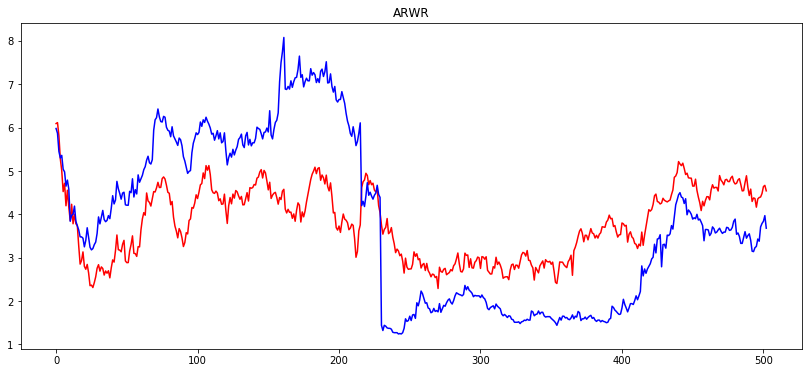

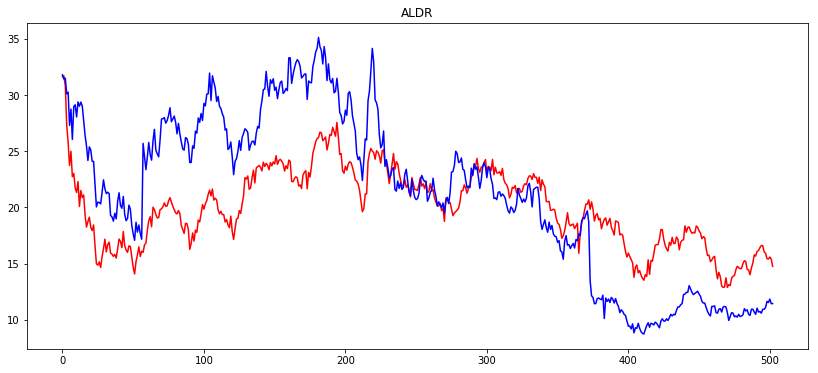

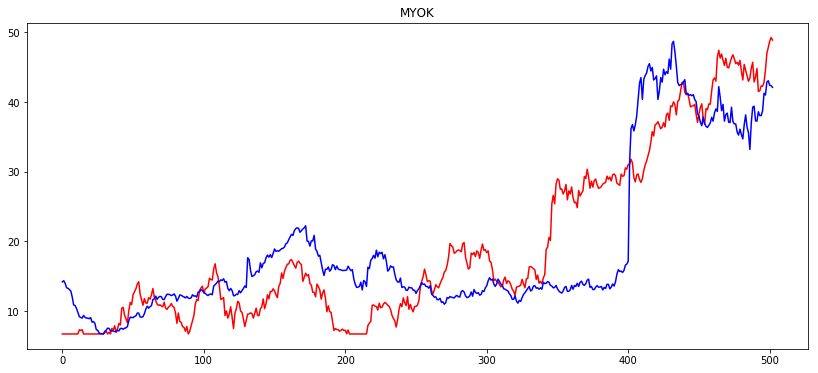

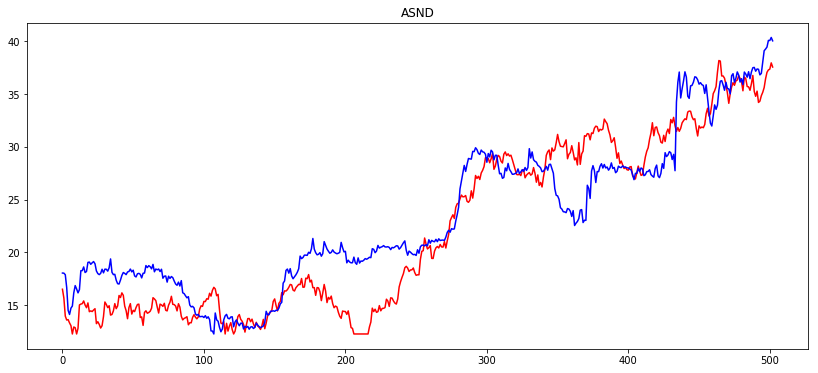

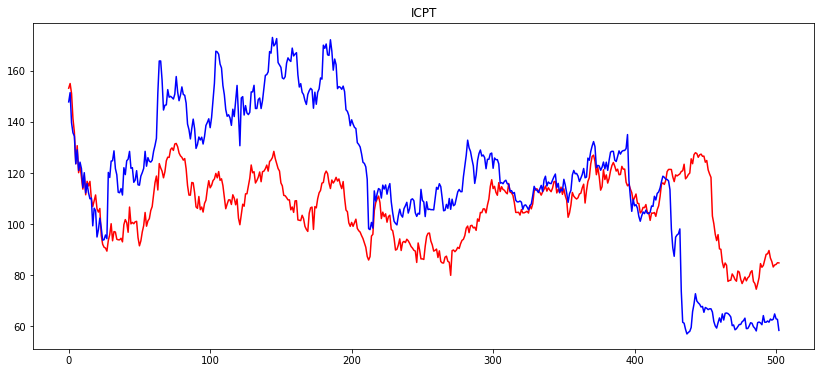

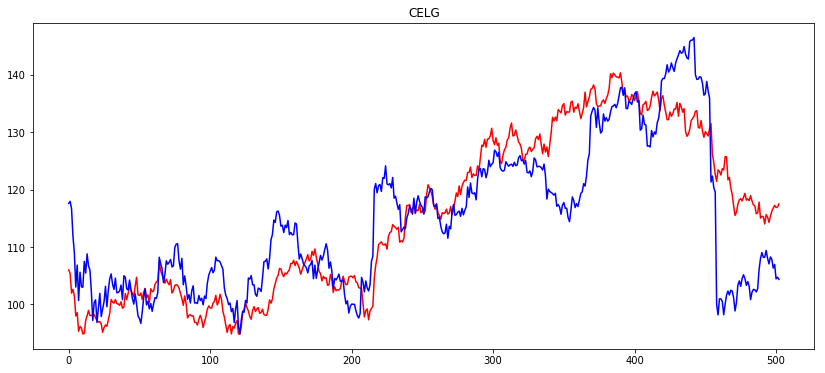

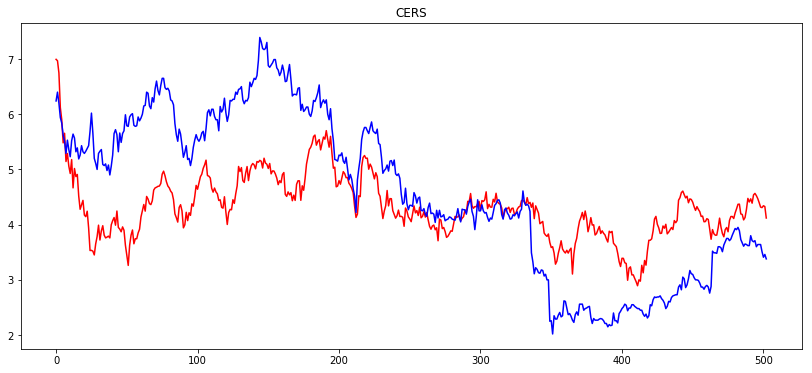

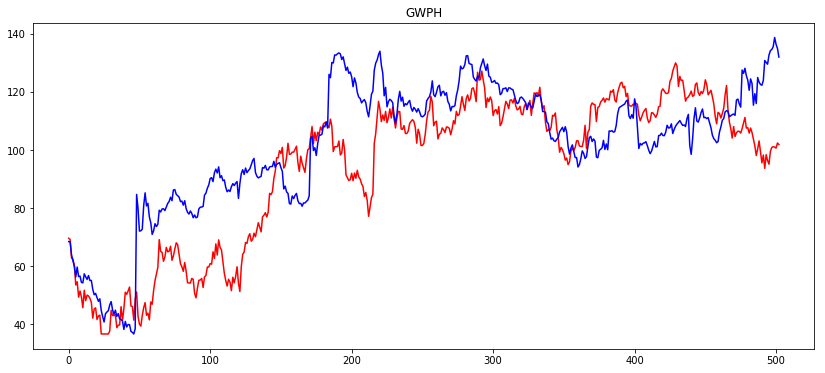

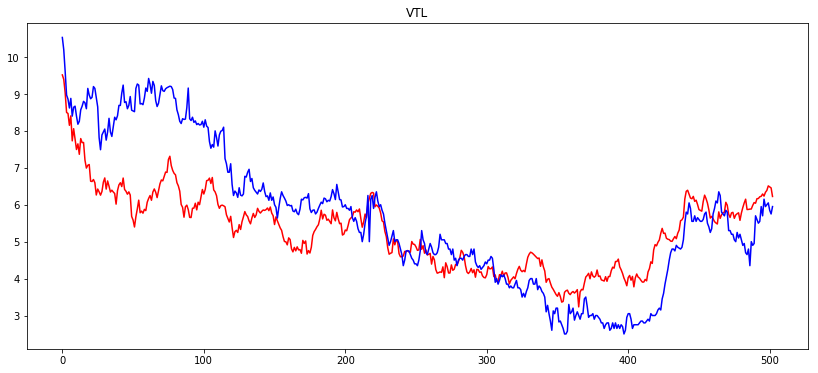

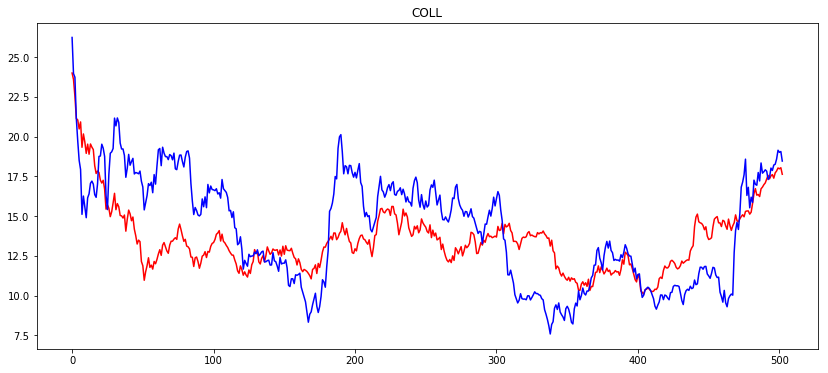

In [47]:
for j in unnormalized_p.keys():
    plt.figure()
    plt.plot(unnormalized_p[j][1] ,'r')
    plt.hold
    plt.plot(test_setData[j] ,'b')
    plt.title(unnormalized_p[j][0])
    plt.show;

# Re checking

In [27]:
diff = abs(p - batch_x)

In [28]:
for i in diff:
    print(i)

[ 0.01671074  0.03595416  0.05328611  0.00343954  0.05152169  0.07529345
  0.0385735   0.06619456  0.0341541   0.06109031  0.00231389  0.03679981
  0.03182744  0.02746055  0.00836947  0.00124613  0.05379045  0.09185832
  0.07971409  0.04633145  0.06580793  0.09749713  0.12361508  0.11902084
  0.12948192  0.11887207  0.13139231  0.12823592  0.11738119  0.11751289
  0.1610577   0.15941735  0.16852282  0.19585721  0.18722589  0.16623036
  0.17809215  0.18591976  0.19958092  0.20098916  0.2166593   0.19618343
  0.17047584  0.18076422  0.20558848  0.19082807  0.17750985  0.17280873
  0.1623244   0.18936386  0.19369237  0.19340153  0.20148747  0.1751878
  0.1924758   0.190036    0.21576105  0.21057357  0.24201192  0.21811174
  0.17231807  0.14690424  0.1449497   0.16376234  0.11073145  0.15062069
  0.13382262  0.14167518  0.13186852  0.2070162   0.24325926  0.23676519
  0.24729076  0.23844921  0.22198935  0.190841    0.20430666  0.2083522
  0.19548885  0.20924431  0.20963909  0.22929779  0.2

In [29]:
print('average error in our case = ',np.mean(diff))

average error in our case =  0.145425385493


In [30]:
random = np.random.uniform(0,1,(10,503))

In [31]:
diff_random = abs(batch_x - random)
print('average error in a random case = ',np.mean(diff_random))

average error in a random case =  0.330744635868


# Finding the commonals

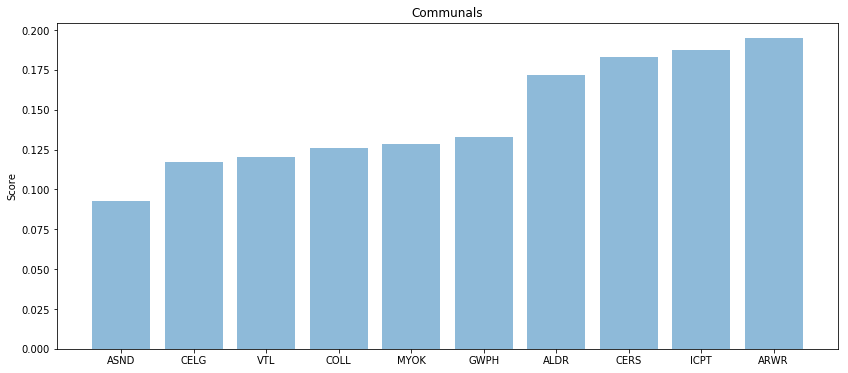

In [44]:



sorted_by_value = []

for i in range(len(p)):
    sorted_by_value.append((np.mean(diff[i]),i))
    
objects =  []
performance = sorted(sorted_by_value)

for i in performance:
    ticker, index = find_ticker_batch(batch_x[i[1]], test_setData_n, list_tickers_test)
    objects.append(ticker)

    
y_pos = np.arange(len(objects))
plotable_performance = [i[0] for i in performance]


plt.bar(y_pos, plotable_performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('Communals')
 
plt.show();


